In [16]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime
import time
import os
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression
import new_sentiment_score

In [17]:
df_income = pd.read_csv('data/income_statement.csv')
df_balance = pd.read_csv('data/balance_sheet.csv')
df_cash_flow = pd.read_csv('data/cash_flow_statement.csv')   
df_earnings = pd.read_csv('data/earnings.csv')   
df_overview = pd.read_csv('data/company_overview.csv')

In [18]:
df_income['fiscalDateEnding'] = pd.to_datetime(df_income['fiscalDateEnding'])
df_balance['fiscalDateEnding'] = pd.to_datetime(df_balance['fiscalDateEnding'])

In [19]:
df_income = df_income.sort_values(by=['symbol', 'fiscalDateEnding'])
df_balance = df_balance.sort_values(by=['symbol', 'fiscalDateEnding'])

In [20]:
for symbol in df_income['symbol'].unique():
    income_data = df_income[df_income['symbol'] == symbol]
    balance_data = df_balance[df_balance['symbol'] == symbol]
    overview_data = df_overview[df_overview['symbol'] == symbol]
    
    # Leverage Ratios
    debt_to_equity  = balance_data['totalLiabilities'].tail(1).values[0] / balance_data['totalShareholderEquity'].tail(1).values[0]
    debt_to_assets = balance_data['totalLiabilities'].tail(1).values[0] / balance_data['totalAssets'].tail(1).values[0]
    interest_coverage = income_data['ebitda'].tail(1).values[0] / income_data['interestExpense'].tail(1).values[0]

    # Liquidity Measures
    current_ratio = balance_data['totalCurrentAssets'].tail(1).values[0] / balance_data['totalCurrentLiabilities'].tail(1).values[0]
    quick_ratio = (balance_data['totalCurrentAssets'].tail(1).values[0] - balance_data['inventory'].tail(1).values[0]) / balance_data['totalCurrentLiabilities'].tail(1).values[0]
    cash_ratio = balance_data['cashAndCashEquivalentsAtCarryingValue'].tail(1).values[0] / balance_data['totalCurrentLiabilities'].tail(1).values[0]

    # Profitability Metrics
    ttm_net_income = sum(income_data['netIncome'].tail(4))
    ttm_revenue = sum(income_data['totalRevenue'].tail(4))
    avg_shareholders_equity = (balance_data['totalShareholderEquity'].tail(5)).mean()
    avg_assets = (balance_data['totalAssets'].tail(5)).mean()

    roe = ttm_net_income / avg_shareholders_equity
    roa = ttm_net_income / avg_assets
    profit_margin = ttm_net_income / ttm_revenue

    # Logarithmic Transformations
    ln_market_cap = np.log(overview_data['MarketCapitalization'].tail(1).values[0])
    ln_total_assets = np.log(balance_data['totalAssets'].tail(1).values[0])    

    # Growth Metrics
    revenue_previous = sum(income_data['totalRevenue'].tail(8).values[0:4]) 
    revenue_growth = ((ttm_revenue - revenue_previous) / revenue_previous)

    earnings_previous = sum(income_data['netIncome'].tail(8).values[0:4])
    earnings_growth = ((ttm_net_income - earnings_previous) / earnings_previous)

    asset_previous = balance_data['totalAssets'].tail(2).values[0] 
    asset_growth = ((balance_data['totalAssets'].tail(1).values[0] - asset_previous) / asset_previous)
    
    indutry_dummies = pd.get_dummies(overview_data['Industry'], prefix='industry', drop_first=True)    

    # Add results to overview DataFrame
    df_overview.loc[df_overview['symbol'] == symbol, 'debt_to_equity'] = debt_to_equity
    df_overview.loc[df_overview['symbol'] == symbol, 'debt_to_assets'] = debt_to_assets
    df_overview.loc[df_overview['symbol'] == symbol, 'interest_coverage'] = interest_coverage
    df_overview.loc[df_overview['symbol'] == symbol, 'current_ratio'] = current_ratio
    df_overview.loc[df_overview['symbol'] == symbol, 'quick_ratio'] = quick_ratio
    df_overview.loc[df_overview['symbol'] == symbol, 'cash_ratio'] =  cash_ratio      
    df_overview.loc[df_overview['symbol'] == symbol, 'ROE'] = roe
    df_overview.loc[df_overview['symbol'] == symbol, 'ROA'] = roa
    df_overview.loc[df_overview['symbol'] == symbol, 'profit_margin'] = profit_margin
    df_overview.loc[df_overview['symbol'] == symbol, 'ln_market_cap'] = ln_market_cap
    df_overview.loc[df_overview['symbol'] == symbol, 'ln_total_assets'] = ln_total_assets       
    df_overview.loc[df_overview['symbol'] == symbol, 'revenue_growth'] = revenue_growth
    df_overview.loc[df_overview['symbol'] == symbol, 'earnings_growth'] = earnings_growth
    df_overview.loc[df_overview['symbol'] == symbol, 'asset_growth'] = asset_growth 
    for col in indutry_dummies.columns:
        df_overview.loc[df_overview['symbol'] == symbol, col] = indutry_dummies[col].values[0]    



In [21]:
df_macro = pd.read_csv('data/macro_data.csv')

In [22]:
df_macro['date'] = pd.to_datetime(df_macro['date'])
df_macro = df_macro.replace(".", np.nan) 
df_macro = df_macro.sort_values(by='date')

In [23]:
df_macro['value'] = pd.to_numeric(df_macro['value'], errors='coerce')

In [24]:
df_10y_treasury = df_macro[(df_macro['function'] == 'Treasury_Yield')& (df_macro['maturity']==10.0)]

In [25]:
df_date = pd.DataFrame({'date':pd.date_range(start='2024-01-01', end='2025-07-02')})

In [26]:
df_daily = df_date.merge(df_10y_treasury, how='left', on='date')

In [27]:
df_daily.rename(columns={'value': '10y_yield'}, inplace=True)

In [28]:
df_daily['10y_yield'] = df_daily['10y_yield'].fillna(method='ffill')

In [29]:
df_daily['week'] = (df_daily['date'] - pd.Timedelta(days=3)).dt.isocalendar().week

In [30]:
df_daily['week'] = df_daily['date'].dt.year.astype(str) + '-' + df_daily['week'].astype(str)

In [31]:
df_daily = df_daily[df_daily['week']!= '2024-52']

In [32]:
df_price = pd.read_csv('data/tech_stock_daily_price.csv')
df_price['Date'] = pd.to_datetime(df_price['Date'])

In [33]:
df_SP500 = pd.read_csv('data/SP500_daily_price.csv')
df_SP500['Date'] = pd.to_datetime(df_SP500['Date'])

In [34]:
load_dotenv()
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

In [35]:
results_df = pd.DataFrame(columns=[
    'Ticker', 
    'Intercept', 
    'Beta_10Y_Treasury', 
    'Beta_SP500', 
    'R_squared'
])

for ticker in df_price['ticker'].unique():

    price_data = df_price[df_price['ticker'] == ticker]
    price_data = price_data.rename(columns={'Date': 'date', 'Close': 'close'})
    price_data['date'] = pd.to_datetime(price_data['date'])

    SPY_500 = df_SP500.rename(columns={'Date': 'date', 'Close': 'SPY_close'})
    SPY_500['date'] = pd.to_datetime(SPY_500['date'])

    # Merge with daily yield data
    merged_data = pd.merge(df_daily, price_data, on='date', how='left')
    merged_data['close'] = merged_data['close'].fillna(method='ffill')

    merged_data = pd.merge(merged_data, SPY_500, on='date', how='left')
    merged_data['SPY_close'] = merged_data['SPY_close'].fillna(method='ffill')

    # Calculate weekly average close price
    merged_data['week'] = merged_data['date'].dt.year.astype(str) + '-' + merged_data['date'].dt.isocalendar().week.astype(str)
    merged_data = merged_data.groupby('week')[['close','10y_yield','SPY_close']].mean().reset_index()
    merged_data.rename(columns={'close': 'weekly_avg_close','10y_yield': 'weekly_avg_yield','SPY_close':'weekly_SPY_close'}, inplace=True)
    merged_data['change_weekly_avg_close'] = merged_data['weekly_avg_close'].pct_change().fillna(0)  
    merged_data['change_weekly_avg_yield'] = merged_data['weekly_avg_yield'].pct_change().fillna(0)
    merged_data['change_weekly_SPY_close'] = merged_data['weekly_SPY_close'].pct_change().fillna(0)

    # Fit regression: stock_return ~ change_10Y_Treasury + sp500_return
    X = merged_data[['change_weekly_avg_yield', 'change_weekly_SPY_close']]
    y = merged_data['change_weekly_avg_close']
    model = LinearRegression()
    model.fit(X, y)

    new_row = pd.DataFrame([{
    'Ticker': ticker,
    'Intercept': model.intercept_,
    'Beta_10Y_Treasury': model.coef_[0],
    'Beta_SP500': model.coef_[1],
    'R_squared': model.score(X, y)
    }])

    results_df = pd.concat([results_df, new_row], ignore_index=True)


In [36]:
df_sector = pd.read_csv('data/sector_data.csv')
df_sector = df_sector.rename(columns={'Symbol': 'Ticker', 'Name': 'Company'})

In [37]:
results_df = results_df.merge(df_sector, how='left', on='Ticker')

In [38]:
results_df.to_csv(f'data/SP500_senstitivity_results.csv', index=False)

In [39]:
results_df.columns

Index(['Ticker', 'Intercept', 'Beta_10Y_Treasury', 'Beta_SP500', 'R_squared',
       'Company', 'Sector'],
      dtype='object')

In [40]:
results_df

,Ticker,Intercept,Beta_10Y_Treasury,Beta_SP500,R_squared,Company,Sector
0,MMM,0.003945,-0.832038,1.403452,0.594193,3M Company,LIFE SCIENCES
1,AOS,-0.000809,-0.291152,0.004625,0.066606,Smith AO Corporation,MANUFACTURING
2,ABT,0.004742,-0.718826,0.044399,0.313207,Abbott Laboratories,LIFE SCIENCES
3,ABBV,0.002787,-0.767742,0.573649,0.553107,AbbVie Inc,LIFE SCIENCES
4,ACN,0.003002,0.089737,-0.270071,0.100186,Accenture plc,TRADE & SERVICES
...,...,...,...,...,...,...,...
494,XYL,0.000818,-0.314021,0.826231,0.437281,Xylem Inc,TECHNOLOGY
495,YUM,0.002691,-0.547640,0.334143,0.259248,Yum! Brands Inc,TRADE & SERVICES
496,ZBRA,0.003056,0.884359,2.101395,0.793269,Zebra Technologies Corporation,TECHNOLOGY
497,ZBH,0.002802,0.198327,-0.685039,0.511690,Zimmer Biomet Holdings Inc,LIFE SCIENCES


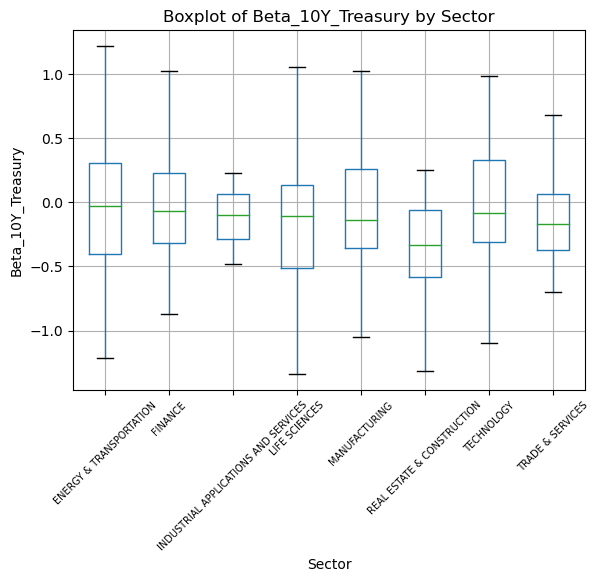

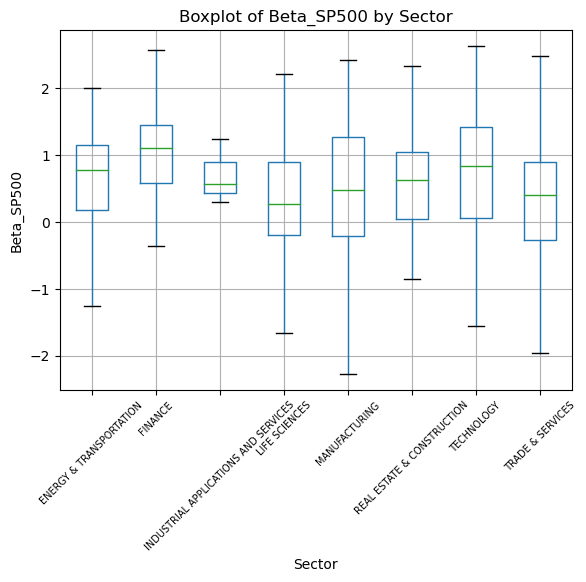

In [47]:
import matplotlib.pyplot as plt

sensitivity = ['Beta_10Y_Treasury','Beta_SP500']

for sen in sensitivity:
    results_df.boxplot(column=sen, by='Sector',showfliers=False)
    plt.title('Boxplot of {} by Sector'.format(sen))
    plt.suptitle('')
    plt.xlabel('Sector')
    plt.xticks(rotation=45, fontsize=7)
    plt.ylabel(sen)
    plt.show()